In [1]:
!pip install geopandas shapely geopy pyproj folium contextily networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.3 MB/s eta 0:00:00


In [2]:
# Imports
# Geometry
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopy.distance import distance
from geopy.distance import geodesic
from shapely.wkt import loads


# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import ast
from pandas.io.json import json_normalize

# Network
import requests
import time
import networkx as nx

In [5]:
# Shape files read and set projection
labota_shp = gpd.read_file("your_path/LaBota.shp")
if labota_shp.crs is None:
    labota_shp.crs = 'epsg:32717'
labota_shp = labota_shp.to_crs('epsg:4326')
# Extract the bounding box of the labota_shp
bbox_bota = labota_shp.total_bounds
polygon_bota = Polygon([(bbox_bota[0], bbox_bota[1]), (bbox_bota[0], bbox_bota[3]), (bbox_bota[2], bbox_bota[3]), (bbox_bota[2], bbox_bota[1])])
# Get the centroid of the bounding box
centroid_bota = polygon_bota.centroid
# Print the centroid coordinates
print(centroid_bota.x, centroid_bota.y)

toctiuco_shp = gpd.read_file("your_path/Toctiuco.shp")
if toctiuco_shp.crs is None:
    toctiuco_shp.crs = 'epsg:32717'
toctiuco_shp = toctiuco_shp.to_crs('epsg:4326')
# Extract the bounding box of the labota_shp
bbox_toctiuco = toctiuco_shp.total_bounds
polygon_toctiuco = Polygon([(bbox_toctiuco[0], bbox_toctiuco[1]), (bbox_toctiuco[0], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[1])])
# Get the centroid of the bounding box
centroid_toctiuco = polygon_toctiuco.centroid
# Print the centroid coordinates
print(centroid_toctiuco.x, centroid_toctiuco.y)

-78.45956887257326 -0.11562405304648693
-78.52568864705847 -0.20985476660321467


In [6]:
# Read POIs
POIS = pd.read_csv("your_path/POIS_final.csv", sep='|')
POIS['lat_rad'] = np.radians(POIS['lat'])
POIS['lon_rad'] = np.radians(POIS['lon'])
LaBota_POI = POIS[POIS['zona_estudio'] == 'LA BOTA']
LaBota_POI = LaBota_POI.dropna(subset=['category'])
toctiuco_POI = POIS[POIS['zona_estudio'] == 'TOCTIUCO']
toctiuco_POI = toctiuco_POI.dropna(subset=['category'])

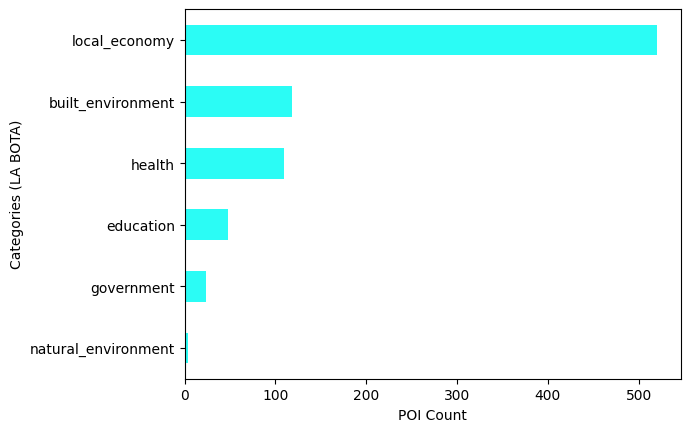

In [7]:
# POIS plots
cat_BOTA = LaBota_POI.groupby(['category'])['name'].count()
cat_BOTA = cat_BOTA.sort_values(ascending=True)
fig, ax1 = plt.subplots()
color = '#2BFCF5'
cat_BOTA.plot(kind='barh', color=color, ax=ax1)
ax1.set_xlabel('POI Count')
ax1.set_ylabel('Categories (LA BOTA)')
plt.show()

In [ ]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/pois_cat_BOTA.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/pois_cat_BOTA.jpg', dpi=300, format='jpeg', bbox_inches='tight')

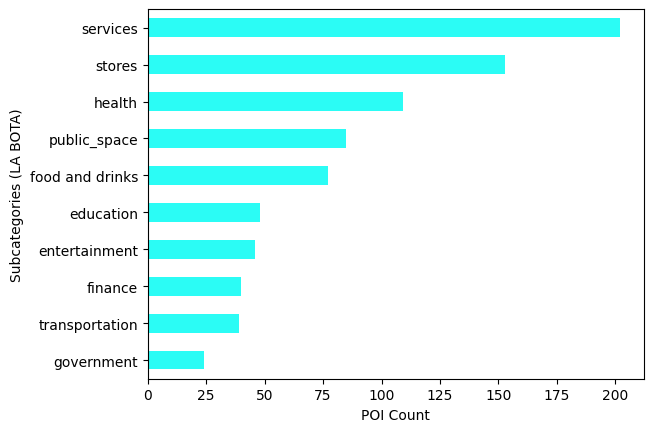

In [8]:
subcat_BOTA = LaBota_POI.groupby(['sub_cat'])['name'].count()
subcat_BOTA =  subcat_BOTA.sort_values(ascending=True)
fig, ax2 = plt.subplots()
color = '#2BFCF5'
subcat_BOTA.plot(kind='barh', color=color, ax=ax2)
ax2.set_xlabel('POI Count')
ax2.set_ylabel('Subcategories (LA BOTA)')
plt.show()

In [ ]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/pois_subcat_BOTA.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/pois_subcat_BOTA.jpg', dpi=300, format='jpeg', bbox_inches='tight')

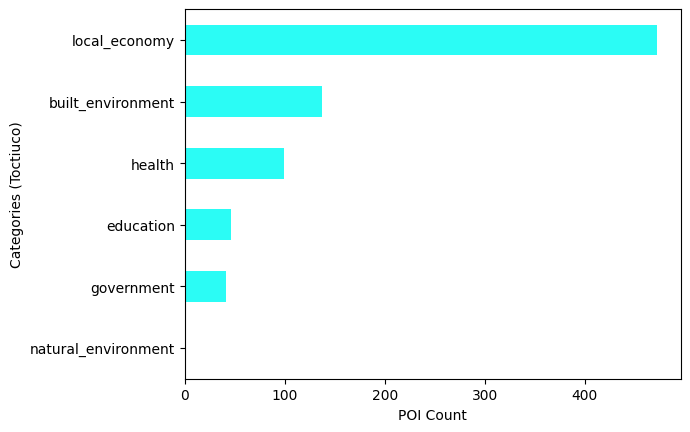

In [9]:
cat_TOC  = toctiuco_POI.groupby(['category'])['name'].count()
cat_TOC  = cat_TOC.sort_values(ascending=True)
fig, ax1 = plt.subplots()
color = '#2BFCF5'
cat_TOC.plot(kind='barh', color=color, ax=ax1)
ax1.set_xlabel('POI Count')
ax1.set_ylabel('Categories (Toctiuco)')
plt.show()

In [ ]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/pois_cat_TOC.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/pois_cat_TOC.jpg', dpi=300, format='jpeg', bbox_inches='tight')

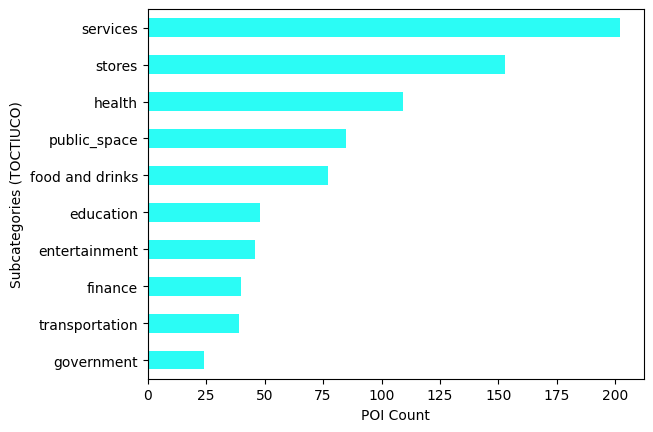

In [ ]:
subcat_TOC = toctiuco_POI.groupby(['sub_cat'])['name'].count()
subcat_TOC =  subcat_TOC.sort_values(ascending=True)
fig, ax2 = plt.subplots()
color = '#2BFCF5'
subcat_BOTA.plot(kind='barh', color=color, ax=ax2)
ax2.set_xlabel('POI Count')
ax2.set_ylabel('Subcategories (TOCTIUCO)')
plt.show()

In [ ]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/pois_subcat_TOC.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/pois_subcat_TOC.jpg', dpi=300, format='jpeg', bbox_inches='tight')

In [10]:
category = 'local_economy'
local_eco_toctiuco = toctiuco_POI[(toctiuco_POI['category'] == category)]
local_eco_labota = LaBota_POI[(LaBota_POI['category'] == category)]

In [11]:
# Cálculo de las distancias entre POIs
def distancia(coord1, coord2):
    return geodesic(coord1, coord2).meters

In [19]:
coordenadas1 = local_eco_toctiuco[['lat', 'lon']].to_numpy()
n_pois = coordenadas1.shape[0]
distancias = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    for j in range(i+1, n_pois):
        dist = distancia(coordenadas1[i], coordenadas1[j])
        distancias[i,j] = dist
        distancias[j,i] = dist
# 10 nearest POIs
indices_cercanos = np.argsort(distancias, axis=1)[:, 1:11]
# Adjacency matrix
adyacencia1 = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    adyacencia1[i, indices_cercanos[i]] = 1
    adyacencia1[indices_cercanos[i], i] = 1

In [20]:
coordenadas2 = local_eco_labota[['lat', 'lon']].to_numpy()
n_pois = coordenadas2.shape[0]
distancias = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    for j in range(i+1, n_pois):
        dist = distancia(coordenadas2[i], coordenadas2[j])
        distancias[i,j] = dist
        distancias[j,i] = dist

# 10 nearest POIs
indices_cercanos = np.argsort(distancias, axis=1)[:, 1:11]
# Adjacency matrix
adyacencia2 = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    adyacencia2[i, indices_cercanos[i]] = 1
    adyacencia2[indices_cercanos[i], i] = 1

In [21]:
# Graph and network
G1 = nx.from_numpy_array(adyacencia1)
G1.remove_edges_from(nx.selfloop_edges(G1))
G2 = nx.from_numpy_array(adyacencia2)
G2.remove_edges_from(nx.selfloop_edges(G2))

In [22]:
# Maps boundaries
def bounding_box_mercator(lat, lon, radius):
    # Define coordinate systems
    wgs84 = CRS("EPSG:4326")  # WGS84
    web_mercator = CRS("EPSG:3857")  # Web Mercator

    # Define transformer
    transformer = Transformer.from_crs(wgs84, web_mercator)

    # Transform lat lon to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(lat, lon)

    # Add/subtract the radius from the projected point
    min_lat = lat_mercator - radius
    max_lat = lat_mercator + radius
    min_lon = lon_mercator - radius
    max_lon = lon_mercator + radius

    return min_lat, min_lon, max_lat, max_lon

# La bota
lat_centroid_bota = centroid_bota.y
lon_centroid_bota = centroid_bota.x
# Toctiuco
lat_centroid_toctiuco = centroid_toctiuco.y
lon_centroid_toctiuco = centroid_toctiuco.x
# Radius
radius = 2750  # meters

min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_centroid_bota, lon_centroid_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_centroid_toctiuco, lon_centroid_toctiuco, radius)

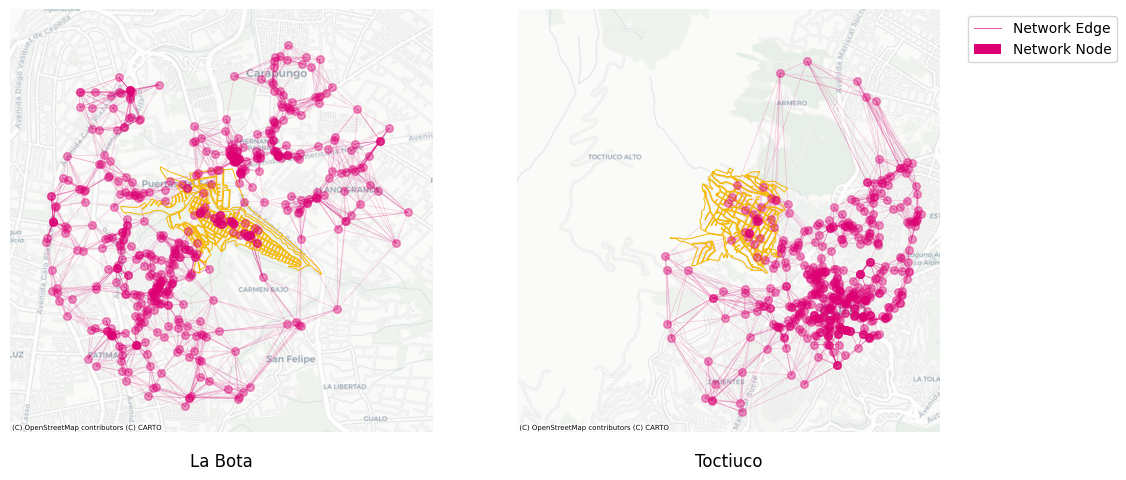

In [34]:
# Convert geodataframe to Web Mercator (epsg:3857)
labota_shp2 = labota_shp.to_crs(epsg=3857)
toctiuco_shp2 = toctiuco_shp.to_crs(epsg=3857)
# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
# Create new Web Mercator coordinates list
coords_web_mercator1 = [transformer.transform(lat, lon) for lat, lon in coordenadas1]
coords_web_mercator2 = [transformer.transform(lat, lon) for lat, lon in coordenadas2]

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Create a position dictionary for nx.draw_networkx
pos = dict(zip(G2.nodes, coords_web_mercator2))

# Draw nodes and edges separately so we can provide them with different colors
labota_shp2.boundary.plot(ax=ax, color='#F5B700', linewidth=0.7)
nx.draw_networkx_nodes(G2, pos=pos, node_size=30, node_color='#DC0073', ax=ax, alpha=0.4)
nx.draw_networkx_edges(G2, pos=pos, width=0.5, edge_color='#DC0073', ax=ax, alpha=0.2)

# Adding contextily basemap

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

# Subplot 1
ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Create a position dictionary for nx.draw_networkx
pos = dict(zip(G1.nodes, coords_web_mercator1))

# Draw nodes and edges separately so we can provide them with different colors
toctiuco_shp2.boundary.plot(ax=ax, color='#F5B700', linewidth=0.7)
nx.draw_networkx_nodes(G1, pos=pos, node_size=30, node_color='#DC0073', ax=ax, alpha=0.4)
nx.draw_networkx_edges(G1, pos=pos, width=0.5, edge_color='#DC0073', ax=ax, alpha=0.2)

# Adding contextily basemap

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Create a list of legend elements
legend_elements = [
        Line2D([0], [0], color='#DC0073', lw=0.5, label='Network Edge'),
        Patch(facecolor='#DC0073', edgecolor='none', label='Network Node'),
]

# Create the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.show()


In [33]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/network_Economy.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/network_Economy.jpg', dpi=300, format='jpeg', bbox_inches='tight')

In [35]:
categorias = ['local_economy', 'education', 'natural_environment', 'built_environment', 'health', 'government']

# Colors for each category
colores = {
    'local_economy': '#DC0073',
    'education': '#FC17E5',
    'natural_environment': '#89FC00',
    'built_environment': '#04E762',
    'health': '#008BF8',
    'government': '#2BFCF5'
}

In [ ]:
coordenadas1 = local_eco_toctiuco[['lat', 'lon']].to_numpy()
n_pois = coordenadas1.shape[0]
distancias = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    for j in range(i+1, n_pois):
        dist = distancia(coordenadas1[i], coordenadas1[j])
        distancias[i,j] = dist
        distancias[j,i] = dist
# 10 nearest POIs
indices_cercanos = np.argsort(distancias, axis=1)[:, 1:11]
# Adjacency matrix
adyacencia1 = np.zeros((n_pois, n_pois))
for i in range(n_pois):
    adyacencia1[i, indices_cercanos[i]] = 1
    adyacencia1[indices_cercanos[i], i] = 1

In [48]:
# Prepare list to store graphs
graphs_list_toc = {}
coords_list_toc = {}
# Loop over categories
for category in categorias:
    # Get data for category
    graph_toctiuco = toctiuco_POI[(toctiuco_POI['category'] == category)]
    # Calculate distances and adjacency for each dataset
    coords = graph_toctiuco[['lat', 'lon']].to_numpy()
    n_pois = coords.shape[0]
    distancias = np.zeros((n_pois, n_pois))
    # Calculate distance between POIs
    for i in range(n_pois):
        for j in range(i+1, n_pois):
            dist = distancia(coords[i], coords[j])
            distancias[i,j] = dist
            distancias[j,i] = dist

    # Get 10 nearest POIs
    indices_cercanos = np.argsort(distancias, axis=1)[:, 1:11]
    # Create adjacency matrix
    adyacencia = np.zeros((n_pois, n_pois))
    for i in range(n_pois):
        adyacencia[i, indices_cercanos[i]] = 1
        adyacencia[indices_cercanos[i], i] = 1

    # Create graph from adjacency matrix and remove self loops
    G = nx.from_numpy_array(adyacencia)
    G.remove_edges_from(nx.selfloop_edges(G))
    graphs_list_toc[category] = G
    coords_list_toc[category] = coords
    graph_toctiuco = graph_toctiuco.reset_index(drop=True)

In [51]:
# Prepare list to store graphs
graphs_list_bota = {}
coords_list_bota = {}
# Loop over categories
for category in categorias:
    # Get data for category
    graph_bota = LaBota_POI[(LaBota_POI['category'] == category)]
    # Calculate distances and adjacency for each dataset
    coords = graph_bota[['lat', 'lon']].to_numpy()
    n_pois = coords.shape[0]
    distancias = np.zeros((n_pois, n_pois))
    # Calculate distance between POIs
    for i in range(n_pois):
        for j in range(i+1, n_pois):
            dist = distancia(coords[i], coords[j])
            distancias[i,j] = dist
            distancias[j,i] = dist

    # Get 10 nearest POIs
    indices_cercanos = np.argsort(distancias, axis=1)[:, 1:11]
    # Create adjacency matrix
    adyacencia = np.zeros((n_pois, n_pois))
    for i in range(n_pois):
        adyacencia[i, indices_cercanos[i]] = 1
        adyacencia[indices_cercanos[i], i] = 1

    # Create graph from adjacency matrix and remove self loops
    G = nx.from_numpy_array(adyacencia)
    G.remove_edges_from(nx.selfloop_edges(G))
    graphs_list_bota[category] = G
    coords_list_bota[category] = coords
    graph_bota = graph_bota.reset_index(drop=True)

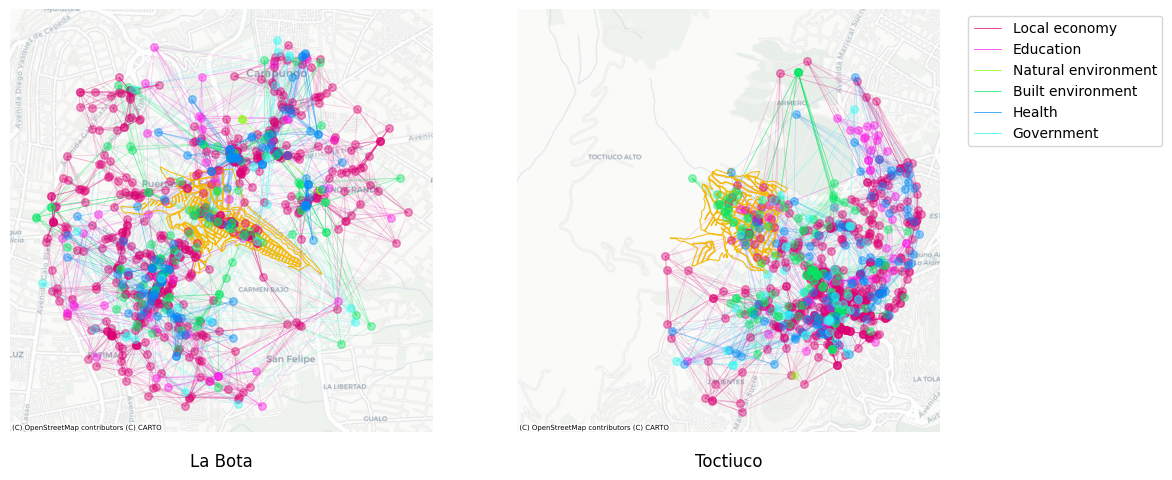

In [52]:
# Convert geodataframe to Web Mercator (epsg:3857)
labota_shp2 = labota_shp.to_crs(epsg=3857)
toctiuco_shp2 = toctiuco_shp.to_crs(epsg=3857)
# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
# Create new Web Mercator coordinates list
coords_web_mercator_LE_bota = [transformer.transform(lat, lon) for lat, lon in coords_list_bota['local_economy']]
coords_web_mercator_ED_bota = [transformer.transform(lat, lon) for lat, lon in coords_list_bota['education']]
coords_web_mercator_NE_bota = [transformer.transform(lat, lon) for lat, lon in coords_list_bota['natural_environment']]
coords_web_mercator_BE_bota = [transformer.transform(lat, lon) for lat, lon in coords_list_bota['built_environment']]
coords_web_mercator_HE_bota = [transformer.transform(lat, lon) for lat, lon in coords_list_bota['health']]
coords_web_mercator_GO_bota = [transformer.transform(lat, lon) for lat, lon in coords_list_bota['government']]

coords_web_mercator_LE_toc = [transformer.transform(lat, lon) for lat, lon in coords_list_toc['local_economy']]
coords_web_mercator_ED_toc = [transformer.transform(lat, lon) for lat, lon in coords_list_toc['education']]
coords_web_mercator_NE_toc = [transformer.transform(lat, lon) for lat, lon in coords_list_toc['natural_environment']]
coords_web_mercator_BE_toc = [transformer.transform(lat, lon) for lat, lon in coords_list_toc['built_environment']]
coords_web_mercator_HE_toc = [transformer.transform(lat, lon) for lat, lon in coords_list_toc['health']]
coords_web_mercator_GO_toc = [transformer.transform(lat, lon) for lat, lon in coords_list_toc['government']]

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Create a position dictionary for nx.draw_networkx
pos1 = dict(zip(graphs_list_bota['local_economy'].nodes, coords_web_mercator_LE_bota))
pos2= dict(zip(graphs_list_bota['education'].nodes, coords_web_mercator_ED_bota))
pos3 = dict(zip(graphs_list_bota['natural_environment'].nodes, coords_web_mercator_NE_bota))
pos4 = dict(zip(graphs_list_bota['built_environment'].nodes, coords_web_mercator_BE_bota))
pos5 = dict(zip(graphs_list_bota['health'].nodes, coords_web_mercator_HE_bota))
pos6 = dict(zip(graphs_list_bota['government'].nodes, coords_web_mercator_GO_bota))

# Draw nodes and edges separately so we can provide them with different colors
labota_shp2.boundary.plot(ax=ax, color='#F5B700', linewidth=0.7)
nx.draw_networkx_nodes(graphs_list_bota['local_economy'], pos=pos1, node_size=30, node_color='#DC0073', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_bota['local_economy'], pos=pos1, width=0.5, edge_color='#DC0073', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_bota['education'], pos=pos2, node_size=30, node_color='#FC17E5', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_bota['education'], pos=pos2, width=0.5, edge_color='#FC17E5', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_bota['natural_environment'], pos=pos3, node_size=30, node_color='#89FC00', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_bota['natural_environment'], pos=pos3, width=0.5, edge_color='#89FC00', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_bota['built_environment'], pos=pos4, node_size=30, node_color='#04E762', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_bota['built_environment'], pos=pos4, width=0.5, edge_color='#04E762', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_bota['health'], pos=pos5, node_size=30, node_color='#008BF8', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_bota['health'], pos=pos5, width=0.5, edge_color='#008BF8', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_bota['government'], pos=pos6, node_size=30, node_color='#2BFCF5', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_bota['government'], pos=pos6, width=0.5, edge_color='#2BFCF5', ax=ax, alpha=0.2)


# Adding contextily basemap

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

# Subplot 1
ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Create a position dictionary for nx.draw_networkx
pos1 = dict(zip(graphs_list_toc['local_economy'].nodes, coords_web_mercator_LE_toc))
pos2= dict(zip(graphs_list_toc['education'].nodes, coords_web_mercator_ED_toc))
pos3 = dict(zip(graphs_list_toc['natural_environment'].nodes, coords_web_mercator_NE_toc))
pos4 = dict(zip(graphs_list_toc['built_environment'].nodes, coords_web_mercator_BE_toc))
pos5 = dict(zip(graphs_list_toc['health'].nodes, coords_web_mercator_HE_toc))
pos6 = dict(zip(graphs_list_toc['government'].nodes, coords_web_mercator_GO_toc))

# Draw nodes and edges separately so we can provide them with different colors
toctiuco_shp2.boundary.plot(ax=ax, color='#F5B700', linewidth=0.7)
nx.draw_networkx_nodes(graphs_list_toc['local_economy'], pos=pos1, node_size=30, node_color='#DC0073', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_toc['local_economy'], pos=pos1, width=0.5, edge_color='#DC0073', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_toc['education'], pos=pos2, node_size=30, node_color='#FC17E5', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_toc['education'], pos=pos2, width=0.5, edge_color='#FC17E5', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_toc['natural_environment'], pos=pos3, node_size=30, node_color='#89FC00', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_toc['natural_environment'], pos=pos3, width=0.5, edge_color='#89FC00', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_toc['built_environment'], pos=pos4, node_size=30, node_color='#04E762', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_toc['built_environment'], pos=pos4, width=0.5, edge_color='#04E762', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_toc['health'], pos=pos5, node_size=30, node_color='#008BF8', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_toc['health'], pos=pos5, width=0.5, edge_color='#008BF8', ax=ax, alpha=0.2)

nx.draw_networkx_nodes(graphs_list_toc['government'], pos=pos6, node_size=30, node_color='#2BFCF5', ax=ax, alpha=0.4)
nx.draw_networkx_edges(graphs_list_toc['government'], pos=pos6, width=0.5, edge_color='#2BFCF5', ax=ax, alpha=0.2)
# Adding contextily basemap

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution_size=5)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Create a list of legend elements
legend_elements = [
        Line2D([0], [0], color='#DC0073', lw=0.5, label='Local economy'),
        Line2D([0], [0], color='#FC17E5', lw=0.5, label='Education'),
        Line2D([0], [0], color='#89FC00', lw=0.5, label='Natural environment'),
        Line2D([0], [0], color='#04E762', lw=0.5, label='Built environment'),
        Line2D([0], [0], color='#008BF8', lw=0.5, label='Health'),
        Line2D([0], [0], color='#2BFCF5', lw=0.5, label='Government'),
]

# Create the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.show()

In [53]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/network_full.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/network_full.jpg', dpi=300, format='jpeg', bbox_inches='tight')